# Exploratory Data Analysis using Spark
### Samantha Patil

#### Reading the chicago_crimes Hive table into PySpark

In [1]:
# Import library
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import to_date
from pyspark.sql import types
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Connect to Spark
spark = SparkSession.builder.enableHiveSupport().appName('ChicagoCrime').getOrCreate()

In [3]:
#Configure Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), 
                                        ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '4'), 
                                        ('spark.cores.max', '4'), 
                                        ('spark.driver.memory','4g')])

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
#print(spark.sparkContext.getConf().getAll())
spark.sparkContext

<SparkContext master=yarn appName=pyspark-shell>

In [4]:
data = spark.read.csv("/user/samanthapatil/data/crime.csv", header=True)

### a. Print basic summary statistics of the data set

In [5]:
data.summary()

summary,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
count,7426512,7426508,7426512,7426512,7426512,7426512,7426512,7417867,7426512,7426512,7426512,7426465,6811674,6813033,7426512,7351979,7351979,7426512,7426512,7351979,7351979,7351979
mean,6750353.775011472,305161.84210526315,null,null,1124.5707293690773,null,null,null,null,null,1187.4553747438906,11.293887199360665,22.72406298363662,37.54223500752161,12.15173388575991,1164564.3031742882,1885731.3640296035,2009.360869274836,null,41.84204310703676,-87.67163002687481,null
stddev,3343644.693846271,134932.50160327618,null,null,813.2941337380714,null,null,null,null,null,702.8726403905715,6.946510687468624,13.83326942398859,21.538727758653852,7.340916718102036,16853.81900187368,32280.183266745084,5.801246962736247,null,0.08881060577430931,0.061101321166378564,null
min,1000,.JB299184,01/01/2001 01:00:...,0000X E 100 PL,0110,ARSON,$300 AND UNDER,"""CTA """"L"""" PLATFORM""",false,false,0111,001,1,0,01A,0,0,2001,01/01/2007 07:32:...,36.619446395,-87.524529378,"(36.619446395, -9..."
25%,3655591.0,161884.0,null,null,560.0,null,null,null,null,null,622.0,6.0,10.0,23.0,6.0,1152951.0,1859077.0,2004.0,null,41.768723739,-87.71377935,null
50%,6740645.0,318876.0,null,null,860.0,null,null,null,null,null,1034.0,10.0,23.0,32.0,11.0,1166061.0,1890659.0,2009.0,null,41.855763923,-87.665970138,null
75%,9677607.0,413567.0,null,null,1320.0,null,null,null,null,null,1731.0,17.0,34.0,57.0,18.0,1176364.0,1909232.0,2014.0,null,41.906704896,-87.62826032,null
max,9999999,ZZZ199957,12/31/2020 12:55:...,XX UNKNOWN,9901,WEAPONS VIOLATION,WIREROOM/SPORTS,YMCA,true,true,2535,031,9,9,26,1205119,1951622,2021,12/31/2020 03:50:...,42.022910333,-91.686565684,"(42.022910333, -8..."


### Dropping the columns beat, ward, latitude and longitude columns

In [6]:
data = data.drop('Beat','Ward','Latitude','Longitude')

In [7]:
data.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'District',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Location']

### Converting remaining columns to appropriate data types. 

In [8]:
data.dtypes

[('ID', 'string'),
 ('Case Number', 'string'),
 ('Date', 'string'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'string'),
 ('Domestic', 'string'),
 ('District', 'string'),
 ('Community Area', 'string'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'string'),
 ('Y Coordinate', 'string'),
 ('Year', 'string'),
 ('Updated On', 'string'),
 ('Location', 'string')]

In [9]:
# Changing the data types and correcting the date to timestamp
data = data.withColumn('Arrest',f.col('Arrest').cast('Boolean'))  \
        .withColumn('Domestic',f.col('Domestic').cast('Boolean'))  \
        .withColumn('Community Area',f.col('Community Area').cast('int')) \
        .withColumn("Date",f.to_timestamp("Date","MM/dd/yyyy hh:mm:ss a")) \
        .withColumn("Updated On",f.to_timestamp("Date","MM/dd/yyyy hh:mm:ss a"))
data.dtypes

[('ID', 'string'),
 ('Case Number', 'string'),
 ('Date', 'timestamp'),
 ('Block', 'string'),
 ('IUCR', 'string'),
 ('Primary Type', 'string'),
 ('Description', 'string'),
 ('Location Description', 'string'),
 ('Arrest', 'boolean'),
 ('Domestic', 'boolean'),
 ('District', 'string'),
 ('Community Area', 'int'),
 ('FBI Code', 'string'),
 ('X Coordinate', 'string'),
 ('Y Coordinate', 'string'),
 ('Year', 'string'),
 ('Updated On', 'timestamp'),
 ('Location', 'string')]

### Adding a month column and community name (from metadata) to the dataset

In [10]:
# Seperating day of week and date and adding the month column
data = data.withColumn('day_of_week',dayofweek(data['Date']))
data = data.withColumn("date",to_date("Date")) 
data = data.withColumn('month',f.month(f.col('Date')))

# Adding community name from metadata
comm_names = spark.read.csv('/user/samanthapatil/data/Community_Areas.csv', header=False, inferSchema=True)
data = data.join(comm_names, data['Community Area'] ==  comm_names['_c0'],"inner")

# Removing duplicate column for Communuty name and cleaning the dataset
data_final = data.withColumnRenamed('_c1','Community Name').drop('_c0')

#Clean dataset
data_final.limit(10)

ID,Case Number,date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Location,day_of_week,month,Community Name
7752369,HS560828,2010-09-28,011XX W WILSON AVE,0460,BATTERY,SIMPLE,COLLEGE/UNIVERSIT...,false,false,019,3,08B,1167612,1930696,2010,2010-09-28 09:00:00,"(41.96538061, -87...",3,9,Uptown
7752370,HS560631,2010-10-12,045XX S LAKE PARK...,0486,BATTERY,DOMESTIC BATTERY ...,APARTMENT,true,true,002,39,08B,1185415,1875033,2010,2010-10-12 12:40:00,"(41.812236418, -8...",3,10,Kenwood
7752371,HS559089,2010-10-11,017XX W 51ST ST,0430,BATTERY,AGGRAVATED: OTHER...,SIDEWALK,false,false,009,61,04B,1165790,1870885,2010,2010-10-11 13:40:00,"(41.801293701, -8...",2,10,New City
7752372,HS560449,2010-10-12,029XX W POPE JOHN...,0560,ASSAULT,SIMPLE,OTHER,false,false,009,58,08A,1157638,1876001,2010,2010-10-12 11:20:00,"(41.815502065, -8...",3,10,Brighton Park
7752373,HS560420,2010-10-12,035XX S WASHTENAW...,0486,BATTERY,DOMESTIC BATTERY ...,APARTMENT,false,true,009,58,08B,1158944,1880905,2010,2010-10-12 00:30:00,"(41.82893261, -87...",3,10,Brighton Park
7752374,HS560682,2010-10-11,054XX W BERENICE AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,false,false,016,15,07,1139385,1925095,2010,2010-10-11 18:00:00,"(41.950573545, -8...",2,10,Portage Park
7752375,HS560176,2010-10-11,034XX N MAJOR AVE,1340,CRIMINAL DAMAGE,TO STATE SUP PROP,"SCHOOL, PUBLIC, B...",false,false,016,15,14,1137757,1922269,2010,2010-10-11 18:00:00,"(41.942848288, -8...",2,10,Portage Park
7752377,HS560749,2010-10-06,093XX S CREGIER AVE,0560,ASSAULT,SIMPLE,RESIDENCE,false,true,004,48,08A,1189813,1843370,2010,2010-10-06 00:01:00,"(41.725245806, -8...",4,10,Calumet Heights
7752378,HS560768,2010-10-12,075XX S CONSTANCE...,0470,PUBLIC PEACE VIOL...,RECKLESS CONDUCT,"SCHOOL, PUBLIC, B...",true,false,004,43,24,1189845,1855351,2010,2010-10-12 13:30:00,"(41.758122033, -8...",3,10,South Shore
7752379,HS560883,2010-10-12,042XX W ARMITAGE AVE,141C,WEAPONS VIOLATION,UNLAWFUL USE OTHE...,SIDEWALK,true,false,025,20,15,1147581,1912945,2010,2010-10-12 15:01:00,"(41.917079254, -8...",3,10,Hermosa


## Exploring data by crime attributes

### Grouping and count crimes where description begins with the word “aggravated”

In [11]:
data_final.filter(data_final['Description'].startswith('AGGRAVATED')).count()

327970

### Crime type most prevalent in apartments and community has it occurred the most in

In [12]:
# Which crime type is the most prevalent in apartments
data_final.filter(data_final['Location Description'] == "APARTMENT")\
    .groupby('Primary Type')\
    .count()\
    .show(1,False)

+--------------------------+-----+
|Primary Type              |count|
+--------------------------+-----+
|OFFENSE INVOLVING CHILDREN|12247|
+--------------------------+-----+
only showing top 1 row



In [13]:
# Which community has it occurred the most
data_final.filter(data_final['Location Description'] == "APARTMENT")\
    .filter(data_final['Primary Type'] == "OFFENSE INVOLVING CHILDREN")\
    .groupby('Community Name')\
    .count()\
    .orderBy('count', ascending=False)\
    .show(1,False)

+--------------+-----+
|Community Name|count|
+--------------+-----+
|Austin        |910  |
+--------------+-----+
only showing top 1 row



- Crime Type = OFFENSE INVOLVING CHILDREN
- Community most occured in =  Austin

### Maximum number of weapons violations per month that occurred in 2020.

In [14]:
data_final.filter(data_final['Year'] == 2020)\
    .filter(data_final['Primary Type'] == 'WEAPONS VIOLATION')\
    .groupby('month')\
    .count()\
    .orderBy('month', ascending=True)

month,count
1,490
2,461
3,464
4,474
5,792
6,782
7,804
8,983
9,831
10,806


### % of the domestic crimes that led to an arrest

In [15]:
data_final.filter((data_final['Domestic'] == True)&(data_final['Arrest'] == True)).count()/data_final\
    .filter(data_final['Domestic'] == True).count()

0.1911093409474101

## Exploring data by date and time

### Week and month for the most and the least crimes on average

In [16]:
data_final.groupby('date','day_of_week','month')\
    .count().dropna().groupby('day_of_week')\
    .avg('count').orderBy('avg(count)', ascending=False)

day_of_week,avg(count)
6,944.126267281106
4,902.5285451197053
7,899.0221198156682
3,896.8057090239411
5,893.3471454880295
2,885.3941068139964
1,854.4884792626729


In [17]:
data_final.groupby('date','day_of_week','month')\
    .count().dropna().groupby('month')\
    .avg('count').orderBy('avg(count)', ascending=False)

month,avg(count)
7,998.5483870967741
8,989.0460829493088
6,982.5079365079365
9,958.9126984126984
5,953.5007680491551
10,941.4851794071762
11,885.6916666666667
4,861.6507936507936
3,819.4285714285714
12,816.1596774193548


- Day of the week with the most crimes on average = Saturday
- Day of the week with the least crimes on average = Monday
- Month with the most crimes on average = July
- Month with the least crimes on average = February

### Date that had the most number of homicides in the dataset. How many days passed between this date and the next highest number of homicides

In [18]:
data_final.filter(data_final['Primary Type'] == 'HOMICIDE')\
    .groupby('date')\
    .count()\
    .orderBy('count','date', ascending=False).limit(2)

date,count
2020-05-31,19
2015-09-02,10


In [19]:
days_passed = datetime.date(2020, 5, 31) - datetime.date(2015, 9, 2)
days_passed

datetime.timedelta(1733)

### Plotting a monthly time series line chart of all crimes for the last 3 years

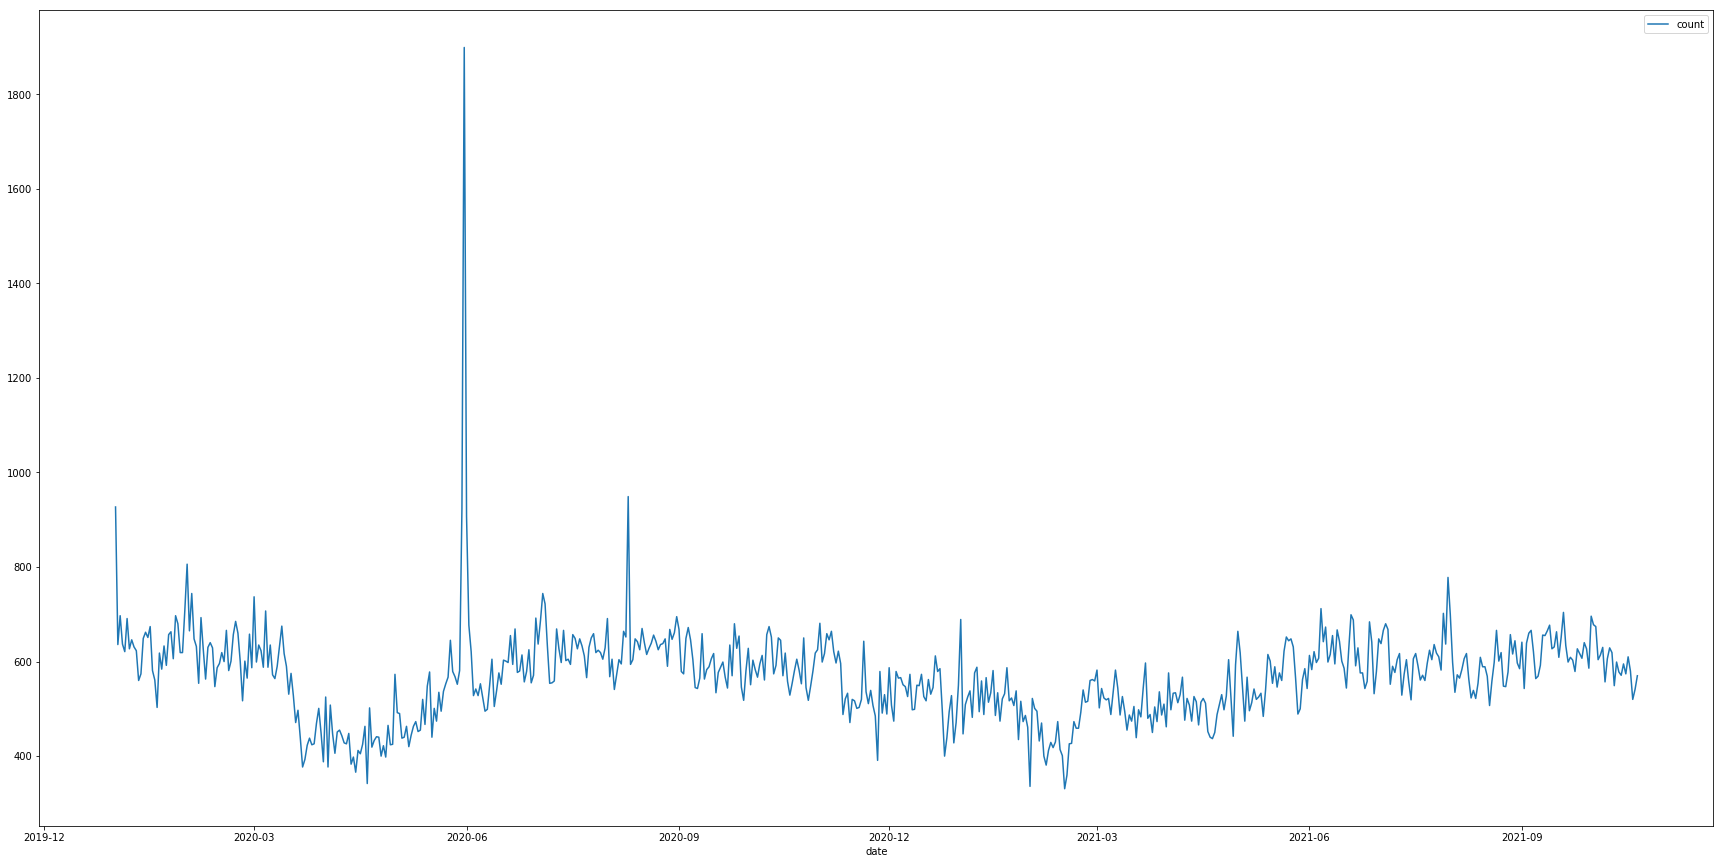

In [20]:
ts = data_final.filter(data_final.Year > 2019).groupby(data_final.date).count().toPandas()
ts = ts.sort_values(['date']).reset_index().drop('index', axis=1)
ts = ts[~ts.date.isna()]
ts.plot(x='date', y='count', figsize=(30,15))

### Ploting a year over year comparison for 3 years (2018, 2019, 2020) by top 5 crime types.

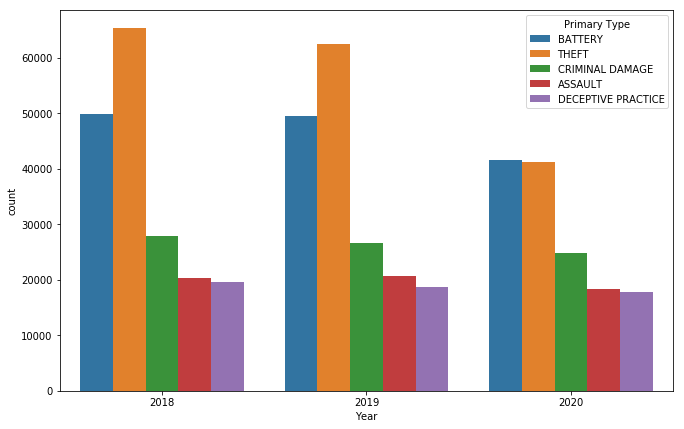

In [21]:
# getting the top 5 crime types for 2018, 2019 & 2020
top_5 = data_final.filter((data_final['Year'] == 2018)|(data_final['Year'] == 2019)|(data_final['Year'] == 2020))\
    .groupby('Year','Primary Type')\
    .count()\
    .orderBy('count',ascending = False)

#using window to partition top 5 crimes by year
window = Window.partitionBy(top_5['Year']).orderBy(top_5['count'].desc())

#plotting the chart
top_5 = top_5\
    .select('*', f.rank().over(window).alias('rank'))\
    .filter(f.col('rank') <= 5)\
    .sort("Year").orderBy(["Year"], ascending=[0])\
    .toPandas()
    
fig, ax = plt.subplots(figsize=(11,7))
sns.barplot(x='Year', y='count', hue='Primary Type', data=top_5, ax=ax)

### Exploring by location


### Using a window function to calculate the community rank based on total crime figures (highest to lowest), where the community with the highest crime will have rank 1. Such that there is 1 row for each community, with a column for the community name and the rank. 

In [22]:
data_final.groupby('Community Name').count()\
    .withColumn("rank",rank().over(Window.partitionBy()\
    .orderBy(col('count').desc()))).limit(10)

Community Name,count,rank
Austin,430021,1
Near North Side,237047,2
South Shore,223967,3
Humboldt Park,214613,4
Near West Side,202941,5
North Lawndale,199567,6
West Town,199422,7
West Englewood,198087,8
Auburn Gresham,193617,9
Roseland,181822,10


### Using a window function to calculate a rolling 7 day sum of crimes over time within each community. Result Set with 3 columns: community, date, and the rolling/lagging 7 day sum.

In [23]:
#cast timestamp to long/number of seconds
cast_ts = lambda i: i * 86400

#creating window
data_final.groupby('Community Name', 'date').count()\
    .orderBy(['Community Name','date'])\
    .withColumn('rolling_7_day_sum', sum("count")
    .over((Window.partitionBy('Community Name')\
    .orderBy(col("date")\
    .cast('timestamp').cast('long'))\
    .rangeBetween(-cast_ts(7), 0)))).limit(10)

Community Name,date,count,rolling_7_day_sum
West Lawn,2001-01-01,1,1
West Lawn,2001-01-12,1,1
West Lawn,2001-02-03,1,1
West Lawn,2001-03-10,1,1
West Lawn,2001-03-24,1,1
West Lawn,2001-05-18,1,1
West Lawn,2001-06-01,1,1
West Lawn,2001-06-30,1,1
West Lawn,2001-07-03,1,2
West Lawn,2001-08-01,1,1


### Using a window functions to calculate a 7 day moving average and cumulative sum of crimes over time within each community. Result set with 4 columns: community, date, the 7 day moving average, and the cumulative sum.

In [24]:
window_1 = (Window.partitionBy('Community Name')\
            .orderBy(col("date")\
            .cast('timestamp').cast('long'))\
            .rangeBetween(-cast_ts(7), 0))

window_2 = (Window.partitionBy('Community Name')
            .orderBy(col("date")\
            .cast('timestamp')\
            .cast('long'))\
            .rowsBetween(Window.unboundedPreceding, Window.currentRow))

data_final.groupby('Community Name', 'date')\
    .count().orderBy(['Community Name','date'])\
    .withColumn('rolling_7_day_avg', avg("count").over(window_1))\
    .withColumn('cumulative_sum', sum("count").over(window_2)).limit(10)

Community Name,date,count,rolling_7_day_avg,cumulative_sum
Hegewisch,null,2,2.0,2
Hegewisch,2001-05-01,1,1.0,3
Hegewisch,2001-05-30,1,1.0,4
Hegewisch,2001-09-05,1,1.0,5
Hegewisch,2001-10-01,2,2.0,7
Hegewisch,2001-10-17,1,1.0,8
Hegewisch,2001-10-18,1,1.0,9
Hegewisch,2001-11-13,1,1.0,10
Hegewisch,2001-11-30,1,1.0,11
Hegewisch,2001-12-12,1,1.0,12


### Cross-tabulating Crime Types vs Location description and visualizing it through a heatmap


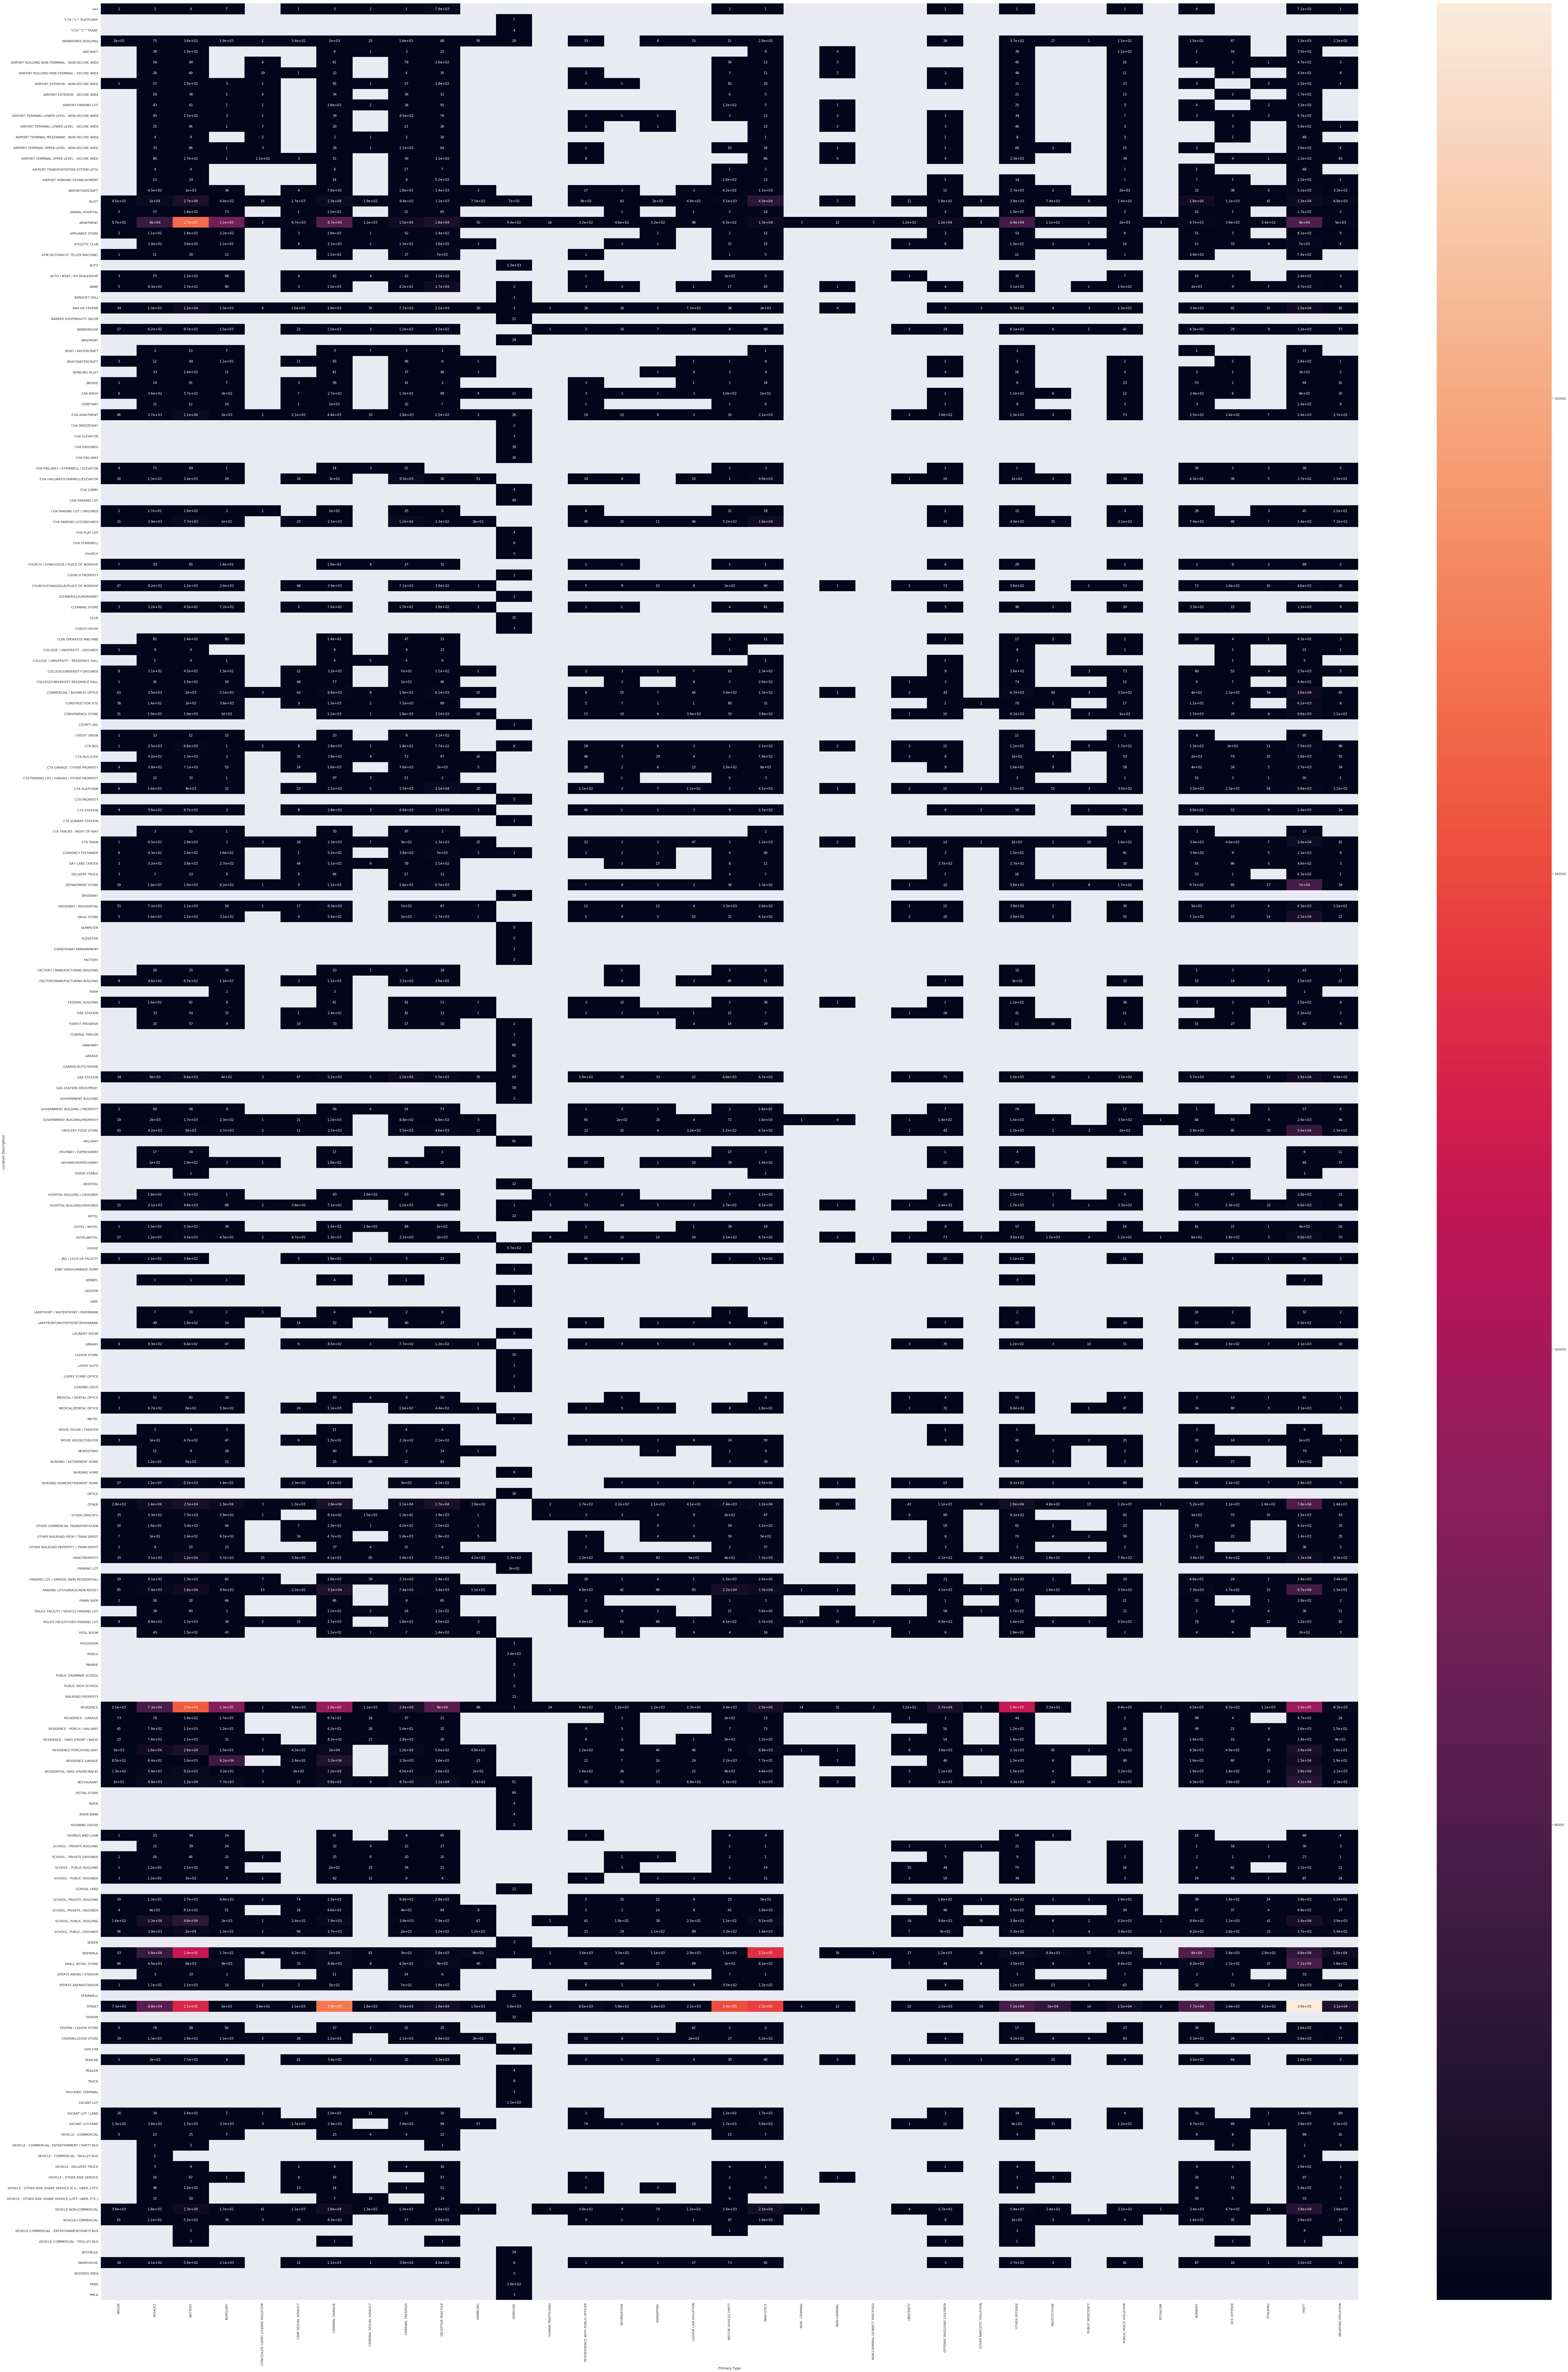

In [25]:
cross_tab = data_final.groupby('Primary Type','Location Description')\
            .count().toPandas()\
            .pivot( "Location Description","Primary Type", "count")
sns.set(rc={'figure.figsize':(100,150)})
sns.heatmap(cross_tab, annot=True)
plt.show()

### Analyzing the Impact of Covid-19 

### Bringing in daily Covid cases data from the City of Chicago data portal and loading into a table chicago_covid in Hive database.

In [26]:
covid19 = spark.read.csv('/user/samanthapatil/data/COVID19.csv', inferSchema = True, header = True)
covid19.limit(10)

Date,Cases,Deaths,Hospitalizations
3/1/2020,0,0,2
3/2/2020,0,0,1
3/3/2020,0,0,3
3/4/2020,0,0,2
3/5/2020,1,0,6
4/21/2020,875,36,171
3/8/2020,3,0,7
10/10/2021,174,6,26
3/10/2020,11,0,5
3/11/2020,13,0,7


In [27]:
# loading into a table chicago_covid in RCC Hive database
from pyspark.sql import HiveContext
sc = spark.sparkContext
hive_context = HiveContext(sc)

hive_context.sql('use samanthapatil');
hive_context.sql("show tables").show();

# writting table to hive
covid19.write.mode('overwrite').saveAsTable('chicago_covid')

+-------------+-------------+-----------+
|     database|    tableName|isTemporary|
+-------------+-------------+-----------+
|samanthapatil|chicago_covid|      false|
+-------------+-------------+-----------+



In [28]:
#reading covid data
covid_df = hive_context.read.table('samanthapatil.chicago_covid')
covid_df.limit(10)

Date,Cases,Deaths,Hospitalizations
3/1/2020,0,0,2
3/2/2020,0,0,1
3/3/2020,0,0,3
3/4/2020,0,0,2
3/5/2020,1,0,6
4/21/2020,875,36,171
3/8/2020,3,0,7
10/10/2021,174,6,26
3/10/2020,11,0,5
3/11/2020,13,0,7


In [29]:
# renaming date col for covid dataset
covid_df = covid_df.withColumnRenamed("Date","CovidDate")

### Creating a summarized daily total counts of the daily crime data by crime type

In [30]:
#daily total counts of the daily crime data by crime type
crime_by_type = data_final.groupby('date','Primary Type').count()
crime_by_type.limit(10)

date,Primary Type,count
2003-07-22,THEFT,319
2003-12-15,ASSAULT,63
2003-07-28,THEFT,338
2003-11-16,CRIMINAL DAMAGE,133
2003-10-01,WEAPONS VIOLATION,15
2003-09-06,THEFT,290
2002-03-12,THEFT,9
2002-02-01,THEFT,89
2003-09-26,OFFENSE INVOLVING...,9
2003-09-13,DECEPTIVE PRACTICE,20


### Joining a daily total covid cases and death data with daily chicago crimes data starting Jan 2020.

In [31]:
# renaming date col for covid dataset
covid_df = covid_df.withColumnRenamed("Date","CovidDate")

#daily total counts of covid cases and deaths
covid_df = covid_df.withColumn('CovidDate',to_date(col("CovidDate"),"MM/dd/yyyy") )
covid_daily_total = covid_df.groupby('CovidDate','Cases', 'Deaths').count()
covid_daily_total.limit(10)

CovidDate,Cases,Deaths,count
2020-08-23,130,1,1
2020-10-15,907,2,1
2021-05-18,286,6,1
2021-10-10,174,6,1
2021-08-18,556,3,1
2021-06-22,33,3,1
2020-12-28,1665,18,1
2020-11-04,2514,8,1
2020-07-25,156,8,1
2021-04-12,863,5,1


In [32]:
#filtering crimes data starting Jan 2020
crime_since_jan20 = crime_by_type.where((crime_by_type['date'] > '2020-01-01')).orderBy('date')
crime_since_jan20 = crime_since_jan20.join(covid_df, crime_since_jan20['date'] ==  covid_df['CovidDate'],"outer").fillna(0).drop('CovidDate')
crime_since_jan20

date,Primary Type,count,Cases,Deaths,Hospitalizations
2020-08-24,ROBBERY,29,554,3,24
2020-08-24,SEX OFFENSE,2,554,3,24
2020-08-24,NARCOTICS,11,554,3,24
2020-08-24,DECEPTIVE PRACTICE,39,554,3,24
2020-08-24,MOTOR VEHICLE THEFT,30,554,3,24
2020-08-24,ASSAULT,55,554,3,24
2020-08-24,THEFT,139,554,3,24
2020-08-24,OTHER OFFENSE,34,554,3,24
2020-08-24,WEAPONS VIOLATION,21,554,3,24
2020-08-24,CRIMINAL DAMAGE,94,554,3,24


### Performing a thorough analysis in PySpark on how Covid-19 has impacted various types of crimes compared to previous years.

In [33]:
### Identifying the top crimes pre covid for 2018 & 2019
pre_covid = crime_by_type.where((crime_by_type['date'] <= '2020-01-01') & (crime_by_type['date'] > '2018-01-01')).orderBy('date')
pre_covid = pre_covid.groupby('Primary Type').avg('count').orderBy(avg('count').desc()).limit(10).toPandas()
pre_covid

,Primary Type,avg(count)
0,THEFT,174.942466
1,BATTERY,136.163014
2,CRIMINAL DAMAGE,74.713699
3,ASSAULT,56.221918
4,DECEPTIVE PRACTICE,52.642466
5,OTHER OFFENSE,46.621918
6,NARCOTICS,39.247945
7,BURGLARY,29.283562
8,MOTOR VEHICLE THEFT,25.902740
9,ROBBERY,24.195890


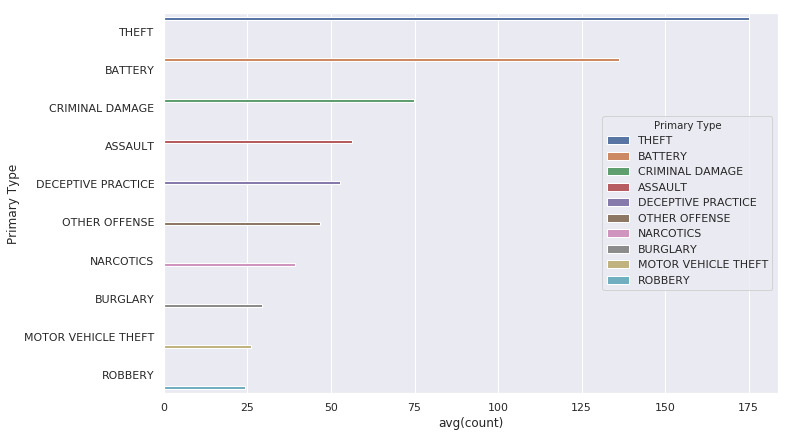

In [34]:
#Plotting the 10 Crimes Pre Covid
fig, ax = plt.subplots(figsize=(11,7))
sns.barplot(x='avg(count)', y='Primary Type', hue='Primary Type',data=pre_covid, ax=ax)

In [37]:
### Identifying the top crimes post covid for 2020
post_covid = crime_by_type.where((crime_by_type['date'] > '2020-01-01')).orderBy('date')
post_covid = post_covid.groupby('Primary Type').avg('count').orderBy(avg('count').desc()).limit(10).toPandas()
post_covid

,Primary Type,avg(count)
0,BATTERY,112.588771
1,THEFT,109.855842
2,CRIMINAL DAMAGE,68.265554
3,ASSAULT,52.699545
4,DECEPTIVE PRACTICE,47.150228
5,OTHER OFFENSE,36.053111
6,MOTOR VEHICLE THEFT,27.206373
7,WEAPONS VIOLATION,23.960546
8,ROBBERY,20.916540
9,BURGLARY,20.726859


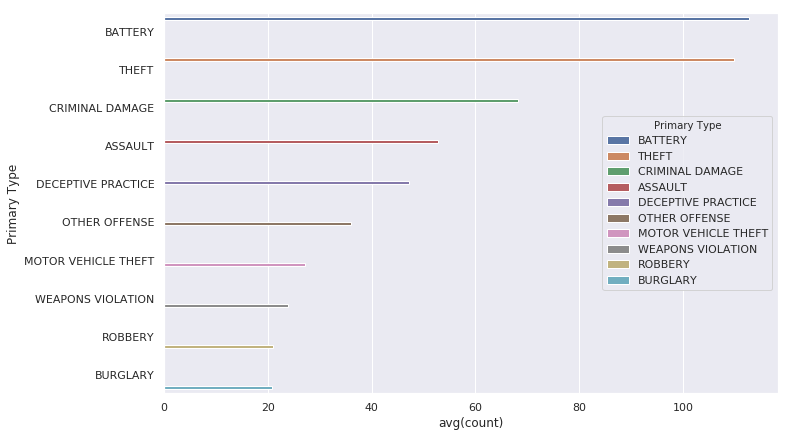

In [38]:
#Plotting the 10 Crimes Post Covid
fig, ax = plt.subplots(figsize=(11,7))
sns.barplot(x='avg(count)', y='Primary Type', hue='Primary Type',data=post_covid, ax=ax)

- Battery and Theft remained the top crime pre and post covid however, battery crime climed to #1 rank in 2020
- Looking at the top 10 averages, we also see an 8% increase in Motor Vehicle Thefts
- Also crimes related to weapons violation had a dramatic increase, averaging about 24 daily, which wasn't in the top 10 list in 2019.

## Thank You